<a href="https://colab.research.google.com/github/katybohanan/Project/blob/main/GAN_generate_synthetic_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kagglehub

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("trolukovich/food11-image-dataset")

print("Path to dataset files:", path)


100%|██████████| 1.08G/1.08G [00:50<00:00, 23.1MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1


In [3]:
!mv /root/.cache/kagglehub/datasets/trolukovich/food11-image-dataset/versions/1 /content/

In [4]:
import os

# Define paths
dataset_path = "/content/1"
train_dir = os.path.join(dataset_path, "training")  # Training images
test_dir = os.path.join(dataset_path, "evaluation")  # Test images
val_dir = os.path.join(dataset_path, "validation")  # Validation images

# List category folders
categories = os.listdir(train_dir)
print("Food Categories:", categories)

Food Categories: ['Rice', 'Soup', 'Dessert', 'Seafood', 'Bread', 'Egg', 'Fried food', 'Dairy product', 'Vegetable-Fruit', 'Noodles-Pasta', 'Meat']


In [5]:
import tensorflow as tf

# Load datasets
IMG_SIZE = (128, 128)  # Resize images
BATCH_SIZE = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Check batch shape
for image_batch, labels_batch in train_data.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Labels batch shape:", labels_batch.shape)


Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.
Found 3347 files belonging to 11 classes.
Image batch shape: (32, 128, 128, 3)
Labels batch shape: (32, 11)


In [6]:
from tensorflow.keras.layers import Conv2DTranspose, LeakyReLU, Dense, Reshape, BatchNormalization
from tensorflow.keras import Input, Model # Importing Input and Model

def build_generator():
    model = tf.keras.Sequential()

    # Input: Noise vector (100,)
    model.add(Dense(16 * 16 * 512, input_dim=100))
    model.add(Reshape((16, 16, 512)))  # Upscale to 16x16

    # Upsample to 32x32
    model.add(Conv2DTranspose(256, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 64x64
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Upsample to 128x128
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Final output layer (128x128x3)
    model.add(Conv2DTranspose(3, kernel_size=4, strides=1, padding='same', activation='tanh'))

    return model

In [7]:
from tensorflow.keras.layers import Conv2D, Flatten, Dropout

def build_discriminator():
    model = tf.keras.Sequential()

    # Input: 128x128x3 image
    model.add(Conv2D(64, kernel_size=4, strides=2, padding='same', input_shape=(128, 128, 3)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Downsample
    model.add(Conv2D(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Downsample further
    model.add(Conv2D(256, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    # Flatten & Output
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))  # Binary classification (real/fake)

    return model


In [8]:
from tensorflow.keras.optimizers import Adam

# Create models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5), metrics=["accuracy"])

# Build combined model (Generator + Discriminator)
z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False  # Freeze discriminator when training GAN
validity = discriminator(img)

# Full GAN Model
gan = Model(z, validity)
gan.compile(loss="binary_crossentropy", optimizer=Adam(0.0002, 0.5))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [9]:
import numpy as np

# Prepare real images from the dataset
def preprocess_images(dataset):
    images = []
    for img_batch, _ in dataset:
        images.append(img_batch.numpy())
    return np.vstack(images)  # Convert list to NumPy array

X_train = preprocess_images(train_data)  # Get images
X_train = (X_train - 127.5) / 127.5  # Normalize to [-1,1]

# Train the GAN
epochs = 10000
batch_size = 32
half_batch = batch_size // 2

for epoch in range(epochs):
    # Train Discriminator
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    real_images = X_train[idx]  # Select real images
    fake_images = generator.predict(np.random.normal(0, 1, (half_batch, 100)))  # Generate fake images

    d_loss_real = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))  # Real = 1
    d_loss_fake = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))  # Fake = 0
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train Generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))  # Fool the discriminator

    # Print progress
    if epoch % 100 == 0:
        print(f"Epoch {epoch}: D Loss: {d_loss[0]}, G Loss: {g_loss}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Streaming output truncated to the last 5000 lines.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 996ms/step


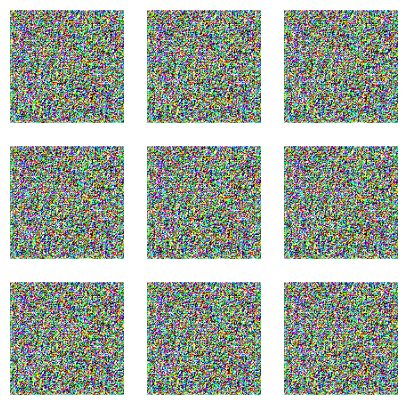

In [10]:
import matplotlib.pyplot as plt

# Generate images
noise = np.random.normal(0, 1, (9, 100))
generated_images = generator.predict(noise)

# Display
plt.figure(figsize=(5, 5))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow((generated_images[i] * 127.5 + 127.5).astype(np.uint8))  # Convert back to 0-255
    plt.axis('off')
plt.show()